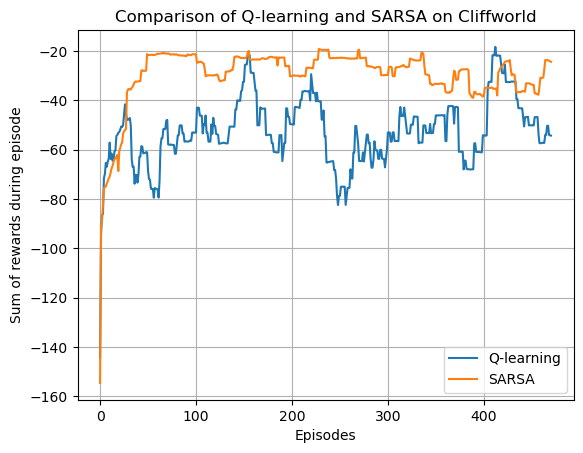

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ============ 新增的平滑函数 ============
def smooth(data, window_size=30):
    """对输入序列做滑动平均，window_size 可根据需要调整。"""
    cumsum_vec = np.cumsum(np.insert(data, 0, 0)) 
    smoothed = (cumsum_vec[window_size:] - cumsum_vec[:-window_size]) / window_size
    return smoothed

# 环境定义，保持与 Cliff Walking 示例一致
class CliffWorld:
    def __init__(self):
        self.height = 4
        self.width = 12
        self.start = (3, 0)
        self.goal = (3, 11)
        self.cliff = [(3, i) for i in range(1, 11)]  # 悬崖区域
        # 上下左右四个动作
        self.actions = [(0, 1), (0, -1), (1, 0), (-1, 0)]

    def step(self, state, action):
        # 计算下一步位置
        next_state = (state[0] + action[0], state[1] + action[1])
        
        # 边界检查：如果超出范围，就留在原地
        if (next_state[0] < 0 or next_state[0] >= self.height or
            next_state[1] < 0 or next_state[1] >= self.width):
            next_state = state

        # 默认每走一步奖励 -1
        reward = -1
        # 如果掉进悬崖，则奖励 -100，并且回到起点
        if next_state in self.cliff:
            reward = -100
            next_state = self.start

        return next_state, reward

# ε-贪心策略
def epsilon_greedy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(len(env.actions))
    else:
        return np.argmax(Q[state[0], state[1]])

# Q-learning
def q_learning(env, episodes, alpha, gamma, epsilon):
    Q = np.zeros((env.height, env.width, len(env.actions)))
    rewards = []

    for _ in range(episodes):
        state = env.start
        total_reward = 0
        
        # 循环直到到达目标
        while state != env.goal:
            action_idx = epsilon_greedy(Q, state, epsilon)
            action = env.actions[action_idx]
            next_state, reward = env.step(state, action)
            best_next_action = np.argmax(Q[next_state[0], next_state[1]])
            
            # Q-learning 更新
            Q[state[0], state[1], action_idx] += alpha * (
                reward + gamma * Q[next_state[0], next_state[1], best_next_action]
                - Q[state[0], state[1], action_idx]
            )

            state = next_state
            total_reward += reward

        rewards.append(total_reward)

    return rewards, Q

# SARSA
def sarsa(env, episodes, alpha, gamma, epsilon):
    Q = np.zeros((env.height, env.width, len(env.actions)))
    rewards = []

    for _ in range(episodes):
        state = env.start
        action_idx = epsilon_greedy(Q, state, epsilon)
        total_reward = 0

        while state != env.goal:
            action = env.actions[action_idx]
            next_state, reward = env.step(state, action)
            next_action_idx = epsilon_greedy(Q, next_state, epsilon)

            # SARSA 更新
            Q[state[0], state[1], action_idx] += alpha * (
                reward + gamma * Q[next_state[0], next_state[1], next_action_idx]
                - Q[state[0], state[1], action_idx]
            )

            state = next_state
            action_idx = next_action_idx
            total_reward += reward

        rewards.append(total_reward)

    return rewards, Q

# ============ 主流程 ============
env = CliffWorld()

# ============ 改为与书中更相似的参数 ============
episodes = 500      # 训练回合数
alpha = 0.5         # 学习率
gamma = 1.0         # 折扣因子
epsilon = 0.1       # ε-贪心概率

# 分别运行 Q-learning 和 SARSA
q_rewards, q_Q = q_learning(env, episodes, alpha, gamma, epsilon)
sarsa_rewards, sarsa_Q = sarsa(env, episodes, alpha, gamma, epsilon)

# 做一下平滑再绘图
plt.plot(smooth(q_rewards), label='Q-learning')
plt.plot(smooth(sarsa_rewards), label='SARSA')
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')
plt.title('Comparison of Q-learning and SARSA on Cliffworld')
plt.legend()
plt.grid(True)
plt.show()


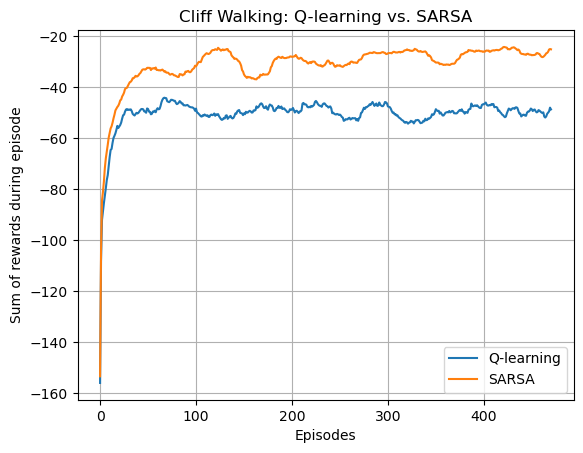

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(307)

def smooth(data, window_size=10):
    # smooth data using a rolling window
    cumsum_vec = np.cumsum(np.insert(data, 0, 0)) 
    smoothed = (cumsum_vec[window_size:] - cumsum_vec[:-window_size]) / window_size
    return smoothed

# ============ 环境定义，与 Cliff Walking 一致 ============
class CliffWorld:
    def __init__(self):
        self.height = 4
        self.width = 12
        self.start = (3, 0)
        self.goal = (3, 11)
        self.cliff = [(3, i) for i in range(1, 11)]
        self.actions = [(0, 1), (0, -1), (1, 0), (-1, 0)]  # 右、左、下、上

    def step(self, state, action):
        r, c = state
        dr, dc = action
        nr, nc = r + dr, c + dc
        
        # 超出边界则不移动
        if nr < 0 or nr >= self.height or nc < 0 or nc >= self.width:
            nr, nc = r, c
        
        reward = -1  # 每走一步默认 -1
        if (nr, nc) in self.cliff:
            # 掉下悬崖 -100 并回到起点
            reward = -100
            nr, nc = self.start
        return (nr, nc), reward

def epsilon_greedy(Q, state, epsilon, env):
    if np.random.rand() < epsilon:
        return np.random.choice(len(env.actions))
    else:
        return np.argmax(Q[state[0], state[1]])

def q_learning(env, episodes, alpha, gamma, epsilon):
    Q = np.zeros((env.height, env.width, len(env.actions)))
    rewards = []

    for _ in range(episodes):
        state = env.start
        total_reward = 0
        while state != env.goal:
            a_idx = epsilon_greedy(Q, state, epsilon, env)
            next_state, reward = env.step(state, env.actions[a_idx])
            best_next_action = np.argmax(Q[next_state[0], next_state[1]])
            
            Q[state[0], state[1], a_idx] += alpha * (
                reward + gamma * Q[next_state[0], next_state[1], best_next_action]
                - Q[state[0], state[1], a_idx]
            )
            state = next_state
            total_reward += reward
        rewards.append(total_reward)
    return rewards

def sarsa(env, episodes, alpha, gamma, epsilon):
    Q = np.zeros((env.height, env.width, len(env.actions)))
    rewards = []

    for _ in range(episodes):
        state = env.start
        a_idx = epsilon_greedy(Q, state, epsilon, env)
        total_reward = 0
        while state != env.goal:
            next_state, reward = env.step(state, env.actions[a_idx])
            next_a_idx = epsilon_greedy(Q, next_state, epsilon, env)
            Q[state[0], state[1], a_idx] += alpha * (
                reward + gamma * Q[next_state[0], next_state[1], next_a_idx]
                - Q[state[0], state[1], a_idx]
            )
            state = next_state
            a_idx = next_a_idx
            total_reward += reward
        rewards.append(total_reward)
    return rewards

def run_experiments(num_runs=30, episodes=500, alpha=0.5, gamma=1.0, epsilon=0.1):
    env = CliffWorld()
    q_all_runs = np.zeros((num_runs, episodes))
    sarsa_all_runs = np.zeros((num_runs, episodes))

    for run in range(num_runs):
        q_rewards = q_learning(env, episodes, alpha, gamma, epsilon)
        sarsa_rewards = sarsa(env, episodes, alpha, gamma, epsilon)
        q_all_runs[run, :] = q_rewards
        sarsa_all_runs[run, :] = sarsa_rewards

    # 取多次平均
    q_mean = np.mean(q_all_runs, axis=0)
    sarsa_mean = np.mean(sarsa_all_runs, axis=0)
    return q_mean, sarsa_mean

if __name__ == "__main__":
    # 运行 30 次，500 回合，超参数与书一致
    episodes = 500
    num_runs = 30
    alpha = 0.5
    gamma = 1.0
    epsilon = 0.1
    
    q_mean, sarsa_mean = run_experiments(num_runs=num_runs, episodes=episodes,
                                         alpha=alpha, gamma=gamma, epsilon=epsilon)

    # 如果想平滑，window_size 可调
    plt.plot(smooth(q_mean, window_size=30), label="Q-learning")
    plt.plot(smooth(sarsa_mean, window_size=30), label="SARSA")

    # plt.plot(q_mean, label="Q-learning")
    # plt.plot(sarsa_mean, label="SARSA")
    plt.xlabel('Episodes')
    plt.ylabel('Sum of rewards during episode')
    plt.title('Cliff Walking: Q-learning vs. SARSA')
    plt.legend()
    plt.grid(True)
    plt.show()

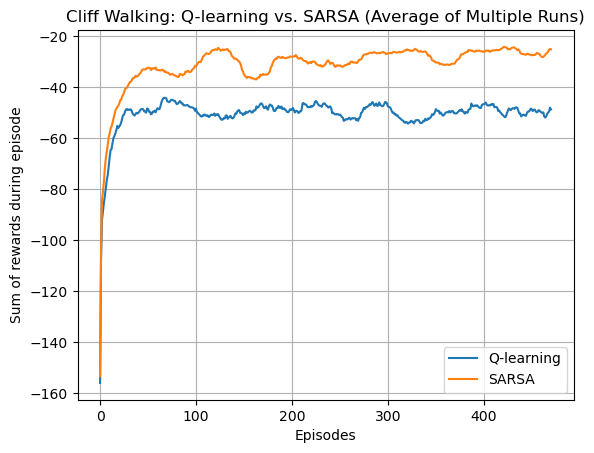


--- Single Run Q-learning ---
Final Episode Reward: -17

Greedy Policy from Q-table:
→ → ← ↑ → → ← ↓ ↓ → → ↓
→ → → → ↓ ↓ → → → ↓ ↓ ↓
→ → → → → → → → → → → ↓
↑ ♦ ♦ ♦ ♦ ♦ ♦ ♦ ♦ ♦ ♦ ★

--- Single Run SARSA ---
Final Episode Reward: -19

Greedy Policy from Q-table:
→ → → → → → → → → → → ↓
↑ ↑ ↑ ↑ → ↑ ↑ ← ↓ ↑ → ↓
↑ → ↑ → ↑ ↑ ↑ ↑ ↑ ↑ → ↓
↑ ♦ ♦ ♦ ♦ ♦ ♦ ♦ ♦ ♦ ♦ ★


In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(307)

def smooth(data, window_size=10):
    """Smooth data using a rolling window."""
    cumsum_vec = np.cumsum(np.insert(data, 0, 0))
    smoothed = (cumsum_vec[window_size:] - cumsum_vec[:-window_size]) / window_size
    return smoothed

# ============ 环境定义，与 Cliff Walking 一致 ============
class CliffWorld:
    def __init__(self):
        self.height = 4
        self.width = 12
        self.start = (3, 0)
        self.goal = (3, 11)
        self.cliff = [(3, i) for i in range(1, 11)]
        # Actions in order: right, left, down, up
        self.actions = [(0, 1), (0, -1), (1, 0), (-1, 0)]

    def step(self, state, action):
        r, c = state
        dr, dc = action
        nr, nc = r + dr, c + dc
        
        # 边界检查
        if nr < 0 or nr >= self.height or nc < 0 or nc >= self.width:
            nr, nc = r, c
        
        # 默认每步 -1
        reward = -1
        # 掉下悬崖
        if (nr, nc) in self.cliff:
            reward = -100
            nr, nc = self.start
        return (nr, nc), reward

def epsilon_greedy(Q, state, epsilon, env):
    """Choose an action index via epsilon-greedy, based on Q at [row, col]."""
    if np.random.rand() < epsilon:
        return np.random.choice(len(env.actions))
    else:
        return np.argmax(Q[state[0], state[1]])

# ------------ 1) 修改 Q-learning 和 sarsa，让它们返回 (rewards, Q) ------------
def q_learning(env, episodes, alpha, gamma, epsilon):
    """
    Q-learning, returning both the list of episode rewards and the final Q table.
    Q shape: (env.height, env.width, number_of_actions).
    """
    Q = np.zeros((env.height, env.width, len(env.actions)))
    rewards = []

    for _ in range(episodes):
        state = env.start
        total_reward = 0
        
        while state != env.goal:
            a_idx = epsilon_greedy(Q, state, epsilon, env)
            next_state, reward = env.step(state, env.actions[a_idx])
            best_next_action = np.argmax(Q[next_state[0], next_state[1]])
            
            Q[state[0], state[1], a_idx] += alpha * (
                reward + gamma * Q[next_state[0], next_state[1], best_next_action]
                - Q[state[0], state[1], a_idx]
            )
            state = next_state
            total_reward += reward

        rewards.append(total_reward)

    return rewards, Q

def sarsa(env, episodes, alpha, gamma, epsilon):
    """
    SARSA, returning both the list of episode rewards and the final Q table.
    """
    Q = np.zeros((env.height, env.width, len(env.actions)))
    rewards = []

    for _ in range(episodes):
        state = env.start
        a_idx = epsilon_greedy(Q, state, epsilon, env)
        total_reward = 0

        while state != env.goal:
            next_state, reward = env.step(state, env.actions[a_idx])
            next_a_idx = epsilon_greedy(Q, next_state, epsilon, env)
            Q[state[0], state[1], a_idx] += alpha * (
                reward + gamma * Q[next_state[0], next_state[1], next_a_idx]
                - Q[state[0], state[1], a_idx]
            )
            state = next_state
            a_idx = next_a_idx
            total_reward += reward

        rewards.append(total_reward)

    return rewards, Q

# ------------ 2) 新增一个打印最终贪心策略的函数 ------------
def print_greedy_policy(env, Q):
    """
    Print the greedy policy (arrows) based on Q.
      - '♦' marks the cliff,
      - '★' marks the goal,
      - arrows for each normal state.
    We assume action indices: 0=→,1=←,2=↓,3=↑
    """
    arrow_map = {0: '→', 1: '←', 2: '↓', 3: '↑'}
    grid = []

    for r in range(env.height):
        row_symbols = []
        for c in range(env.width):
            if (r, c) == env.goal:
                row_symbols.append('★')
            elif (r, c) in env.cliff:
                row_symbols.append('♦')
            else:
                best_a = np.argmax(Q[r, c])  # find the best action at (r,c)
                row_symbols.append(arrow_map[best_a])
        grid.append(row_symbols)

    print("\nGreedy Policy from Q-table:")
    for row in grid:
        print(" ".join(row))

# 保留多次运行仅返回平均奖励的函数
def run_experiments(num_runs=30, episodes=500, alpha=0.5, gamma=1.0, epsilon=0.1):
    env = CliffWorld()
    q_all_runs = np.zeros((num_runs, episodes))
    sarsa_all_runs = np.zeros((num_runs, episodes))

    for run in range(num_runs):
        q_rewards, _ = q_learning(env, episodes, alpha, gamma, epsilon)
        sarsa_rewards, _ = sarsa(env, episodes, alpha, gamma, epsilon)
        q_all_runs[run, :] = q_rewards
        sarsa_all_runs[run, :] = sarsa_rewards

    # 取多次平均
    q_mean = np.mean(q_all_runs, axis=0)
    sarsa_mean = np.mean(sarsa_all_runs, axis=0)
    return q_mean, sarsa_mean

if __name__ == "__main__":
    # -- 1) 先做多次平均实验，画图对比 --
    episodes = 500
    num_runs = 30
    alpha = 0.5
    gamma = 1.0
    epsilon = 0.1
    
    q_mean, sarsa_mean = run_experiments(num_runs=num_runs, episodes=episodes,
                                         alpha=alpha, gamma=gamma, epsilon=epsilon)

    plt.plot(smooth(q_mean, window_size=30), label="Q-learning")
    plt.plot(smooth(sarsa_mean, window_size=30), label="SARSA")
    plt.xlabel('Episodes')
    plt.ylabel('Sum of rewards during episode')
    plt.title('Cliff Walking: Q-learning vs. SARSA (Average of Multiple Runs)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # -- 2) 再做单次运行，打印出该单次训练后的贪心策略 --
    #    （这样我们有一个具体的Q可以展示。）
    env = CliffWorld()
    single_run_episodes = 500
    single_run_alpha = 0.5
    single_run_gamma = 1.0
    single_run_epsilon = 0.1

    # Run Q-learning once, then print the final policy
    q_rewards_single, Q_qlearning = q_learning(env, single_run_episodes,
                                               single_run_alpha,
                                               single_run_gamma,
                                               single_run_epsilon)
    print("\n--- Single Run Q-learning ---")
    print("Final Episode Reward:", q_rewards_single[-1])
    print_greedy_policy(env, Q_qlearning)

    # Run SARSA once, then print the final policy
    sarsa_rewards_single, Q_sarsa = sarsa(env, single_run_episodes,
                                          single_run_alpha,
                                          single_run_gamma,
                                          single_run_epsilon)
    print("\n--- Single Run SARSA ---")
    print("Final Episode Reward:", sarsa_rewards_single[-1])
    print_greedy_policy(env, Q_sarsa)
